## Setup

To prepare the content for this workbook please execute the notebook cell immediately below. You can usually do that via the shortcut <b>&lt;shift&gt;+&lt;return&gt;</b>.

In [1]:
# Please execute this cell before starting the workbook: this should print out "Your notebook is ready to go"
import sys
import tskit
import msprime

if "pyodide" in sys.modules: # if running in-browser (e.g. using JupyterLite)
    import tqdm
    import micropip
    await micropip.install(['jupyterquiz', 'tszip'])

import genealogical_analysis_workshop

workbook = genealogical_analysis_workshop.setup_workbook1()
display(workbook.setup)

## Using this workbook

This workbook is intended to be used by executing each cell as you go along. Code cells (like those above) can be modified and re-executed to perform different behaviour or additional analysis. You can use this to complete various programming exercises, some of which have associated questions to test your understanding. Exercises are marked like this:
<dl class="exercise"><dt>Exercise XXX</dt>
<dd>Here is an exercise: normally there will be a code cell below this box for you to work in</dd>
</dl>

# Genealogical analysis: a very short primer

Most people are familiar with the idea of a family tree: a genealogy that shows the paths of inheritance between a group of related individuals. For clarity we refer to this sort of genealogy as a *pedigree*. The phase "family tree" is misleading, because one individual in the pedigree can be related to another through multiple routes (i.e. the pedigree may not be a strictly dividing tree but a reticulated *network* in which branches can join back to each other).

A *genetic genealogy* also describes a network of inheritance, but focusses explicitly on the transmission of DNA. In particular:
1. A genetic genealogy must specify the *region* of DNA that is transmitted. Regions of DNA are usually quoted by specifying a left and a right position along a genome of fixed size, e.g. a region from position 10kb to 20kb along chromosome 1.
2. At any precise genomic position, inheritance can only come from one parent (i.e. a single DNA letter must have come from the mother or the father, not both)
3. A genetic genealogy shows relationships between *genomes*, not individuals. Each individual can contain multiple genomes; most organisms, including humans, are diploid, meaning that they contain two genomes: one maternal and one paternal.
4. If mutations are overlaid onto the genealogy, the genomes within it will differ in DNA sequence. Hence coupling genetic genealogies with mutations provides a way to encode genetic variation data (this turns out to be extraordinarily powerful).

An entire genetic genealogy showing the network of genetic relationships between a set of genomes (often called the "samples"), is sometimes loosely referred to as an Ancestral Recombination Graph, or ARG. Commonly, the sample genomes are taken from the modern day, and the genealogy shows the ancestral relationships between them, over different regions of the genome.

As a result of point 2. above, these genealogical networks have an amazingly useful property: **at any specific point in the genome** the relationship between the samples can be drawn as a strictly dividing tree. This is sometimes called a "gene tree"; a more accurate name is a "local tree", because it is specific to a local section of the genome (which might not coincide with the boundaries of a specific gene). If we look along the genome, at a different region, the tree is likely to be different, reflecting the fact that this different section of DNA traces a different path back through history (e.g. via the first sample's grandmother rather than their grandfather). However, parts of the genome that are close to each other along the chromosome are likely to share inheritance paths, and so adjacent trees are often highly *correlated*.

A common way to store these genealogical networks, which emphasises that they can also be thought of as a set of correlated trees, is the *succinct tree sequence* format, as implemented in the `tskit` software library.

# Getting started with `tskit`, the tree sequence toolkit.

## What is `tskit`?

`Tskit` is a powerful software library that can be used to deal with population-scale genomic data. It does so by efficiently storing and processing genetic genealogies and ancestral recombination graphs (ARGs) in the <a href="https://tskit.dev/tutorials/what_is.html">succinct tree sequence</a> format. There is extensive <a href="https://tskit.dev/tskit/docs/stable/introduction.html">online documentation</a> along with a set of <a href="https://tskit.dev/tutorials/intro.html">online tutorials</a>, one of which <a href="https://tskit.dev/tutorials/getting_started.html">forms the rough basis</a> for this workbook.

<div class="alert alert-block alert-info">
    <b>Note:</b> This workbook uses the tskit <a href="https://tskit.dev/tskit/docs/stable/python-api.html#sec-python-api">Python API</a> so assumes a basic knowledge of Python, but it's also possible to
<a href="https://tskit.dev/tutorials/tskitr.html">use R</a>, or access the API in other languages, notably
<a href="https://tskit.dev/tskit/docs/stable/c-api.html#sec-c-api">C</a> and <a href="https://github.com/tskit-dev/tskit-rust">Rust</a>.
</div>

## Obtaining a tree sequence

Genetic genealogies in the form of tree sequences can be obtained by simulation or inference from real data. In the next practical we shall explore both methods. If you have time at the end, there is also opportunity to look at another tree sequence inferred from a large human dataset. However, for the time being, we will simply work on a pre-existing tree sequences from a simple simulation of selection on a 1Mb section of genome. 

In [2]:
import tskit
ts = tskit.load("data/simulated.trees")
print("Loaded the tree sequence into a variable called `ts`")

Loaded the tree sequence into a variable called `ts`


You can print the actual tree sequence, but because tree sequences are designed to store huge amounts of genomic data, rather than attempting to print all the data to screen, a summary table is printed. Try it below:

In [3]:
# Print a summary of the tree sequence
print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         40║
╟───────────────┼───────────╢
║Sequence Length│    1000000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │         20║
╟───────────────┼───────────╢
║Total Size     │   16.5 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 150│  4.7 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  10│458 Bytes│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │ 100│  3.6 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  73│  2.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   1│224 Bytes│         Yes║
╟───────────┼────┼────

In a Jupyter notebook, a nicer equivalent is available via the built-in `display` function. Note that this built-in function is automatically applied to the final output of each Jupyter notebook cell, so it's actually redundant in the cell below 

In [4]:
# Display `ts` to the screen, formatted nicely in a Jupyter notebook.
# You can also just write `ts` on its own (modify the code below to try it!)

display(ts)  # Since it is the final cell output, just `ts` also works

## Tree sequence attributes

Various useful properties of the tree sequence are tabulated above, such as the number of trees, the number of sample nodes (i.e. sampled genomes), the sequence length (conventionally interpreted as the number of base pairs), and so on. These are also available as Python attributes:

In [5]:
print(ts.num_trees, "trees")
print(ts.num_samples, "sample nodes (i.e. sampled genomes)")
print("This tree sequence covers", ts.sequence_length, "basepairs")

40 trees
20 sample nodes (i.e. sampled genomes)
This tree sequence covers 1000000.0 basepairs


The tabular summary also prints information on the basic entities in the tree sequence, such as nodes & edges, sites & mutations, and individuals & populations, which are stored in the internal [tables](https://tskit.dev/tutorials/tables_and_editing.html#correspondence-between-tables-and-trees) of a tree sequence object.

<dl class="exercise"><dt>Exercise 1</dt>
<dd>Modify the code cell below to print out not just the number of nodes, but also the number of edges, sites and mutations (and check it corresponds to the counts reported in the summary above). Complete the questions which should appear in the cell below that, pressing return after each entry to see if you got them right</dd></dl>

In [6]:
# Exercise 1: modify me
print("The tree sequence has", ts.num_nodes, "nodes, of which", ts.num_samples, 'are "sample nodes"')


The tree sequence has 73 nodes, of which 20 are "sample nodes"


In [7]:
# Execute this cell to see the questions: press return in each box to check the answer
workbook.Q1()

<IPython.core.display.Javascript object>

## IDs in `tskit`

Nodes, sites, mutations, etc in `tskit` are referred to by their integer IDs. For instance, we often want to refer to the sample nodes in a tree sequence, representing those genomes for which we have sampled DNA data (often sampled at time 0, the most recent timepoint). These node IDs can be obtained using the [`.samples()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.samples) method:

<div class="alert alert-block alert-info">
    <b>Note:</b> Is is common to find that the samples are the first nodes in the tree sequence (IDs <code>0</code> to <code>num_samples-1</code>) but this doesn't have to be the case. Therefore you should always use <code>.samples()</code> to get the sample IDs, rather than using fixed numbers.
</div>

In [8]:
# This is a very useful way to get the IDs of the sample nodes
sample_node_ids = ts.samples()
print("The tree sequence has", ts.num_nodes, "nodes; the *sample* nodes are the ones with these node IDs:")
print(sample_node_ids)

The tree sequence has 73 nodes; the *sample* nodes are the ones with these node IDs:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


We can use these node IDs in further analysis. For example, we saw that this tree sequence contains sites and associated mutations, so it encodes genetic variation data for the samples. Here's an illustration of outputting the variable sites for a few sample node IDs, via the somewhat inefficient [`.haplotypes()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.haplotypes) method (later we'll see how to use the [`.variants()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.variants) method to do this more efficiently, site-by-site)

In [9]:
import numpy as np  # The `tskit` Python API makes extensive use of the numerical python library "numpy"
random_sample_ids = np.random.choice(ts.samples(), size=3, replace=False)

haplotype_iterator = ts.haplotypes(samples=random_sample_ids)  # NB: the haplotypes() method is not very efficient.

for node_id, hap in zip(random_sample_ids, haplotype_iterator):
    print(f"Sample node {node_id}:", hap)

Sample node 8: CCACTGCCGATCTAGACCGGGTTGCGCCTGTTACAGGTTGAGCGATCTCGGGGTGCGACAACCACCCCTTAATTGACCCCTCTTTTCGATCCTGGCAAA
Sample node 17: AAAGACTACCCTTCCCGTTGTGGACATCTATCGATGGCTGAGCGGCCTCGGGCTCCGACAACCACCCCTTAATGGACCCCCCTTTTCGATCCTGGCAAA
Sample node 5: CCACTGCCGACCTACCGTTGTGGACATCTATCGATGATTAAGCGGTCTCGGCGTGCGACAACCACCCCTTAATTGACCCCTCTTTTCGATCCTGGCAAA


## Getting help

The attributes and methods in `tskit` have extensive [online documentation](https://tskit.dev/tskit/docs/stable/python-api.html). For example, detailed information about the `.sequence_length` attribute is available [here](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.sequence_length). For quick reference, the same information (although not as nicely formatted) can be accessed within a notebook as follows:

In [10]:
# Access help via `?` on an existing tree sequence or via e.g. `?tskit.TreeSequence.sequence_length`
?ts.sequence_length

Type:        property
String form: <property object at 0x163a15d00>
Docstring:  
Returns the sequence length in this tree sequence. This defines the
genomic scale over which tree coordinates are defined. Given a
tree sequence with a sequence length :math:`L`, the constituent
trees will be defined over the half-closed interval
:math:`[0, L)`. Each tree then covers some subset of this
interval --- see :attr:`tskit.Tree.interval` for details.

:return: The length of the sequence in this tree sequence in bases.
:rtype: float

<dl class="exercise"><dt>Exercise 2</dt>
<dd>Show the help page for the <code>.samples()</code> tree sequence method</dd>
</dl>

In [11]:
# Exercise 2: add a command below to show help text on the .samples() method


In [12]:
workbook.Q2a()

<IPython.core.display.Javascript object>

In [13]:
# And here's a few bonus questions whose answers may not have been explicitly discussed
workbook.Q2b()

<IPython.core.display.Javascript object>

## Tree sequence entities

<code>Tskit</code> provides some helpful methods for accessing information about the basic entities in a tree sequence. For example <code>ts.node(7)</code> will return a <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Node">node object</a> that contains information about node 7, whereas <code>ts.nodes()</code> will iterate over all the node objects in the tree sequence.

Similarly, <code>ts.site(9)</code> will return a single <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Site">site object</a> and <code>ts.sites()</code> will iterate over all the sites.

<dl class="exercise"><dt>Exercise 3</dt>
<dd>Use the tree sequence `.site()` method to look at sites 11 and 12</dd>
</dl>

In [14]:
# Exercise 3: print out the site object for site 11 and again for site 12


In [15]:
workbook.Q3()

<IPython.core.display.Javascript object>

### Getting hold of a tree

At any genomic location, a tree sequence can be resolved into a single tree, formed of a subset of the nodes and edges, extracted from the underlying tables.

The `tskit` library does all the hard work of constructing these trees from the tree sequence tables, via methods which return a <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Tree">Tree</a> object. As with a tree sequence, when displayed in a notebook, a tree is shown as a summary table, rather than explictly drawn out, because is it normal to have trees of thousands or millions of samples, which can be problematic to draw.

In [16]:
ts.first()  # The first tree in the tree sequence (tree number 0)

In [17]:
ts.at(100_000) # The tree at position 100Kb: this is tree number 6 (i.e. it is the 7th tree)

In [18]:
tree = ts.last()
print(f"The last tree (index {tree.index}) covers bases {tree.interval.left} to {tree.interval.right}\n")

# The `breakpoints` method is a quick way to get the genomic positions ("intervals") of all the trees
print(f"The breakpoints along the genome between the {ts.num_trees} trees are at the following positions:")
print(f" {ts.breakpoints(as_array=True)}")

The last tree (index 39) covers bases 921732.0 to 1000000.0

The breakpoints along the genome between the 40 trees are at the following positions:
 [      0.   39366.   66037.   68538.   88551.   89394.   99631.  137647.
  141520.  145073.  180647.  182618.  191711.  258560.  269834.  295761.
  318254.  466668.  471046.  560552.  584923.  586637.  605902.  612420.
  617792.  626766.  636180.  669823.  697438.  727683.  758854.  770001.
  788668.  821418.  847434.  908601.  908604.  910965.  912828.  921732.
 1000000.]


## Visualising a tree

Since there are relatively few samples in this tree sequence, we can easily draw one of the local trees. This can be done using text or Scalable Vector Graphic (SVG) format:

In [19]:
tree = ts.first()
tree_as_text = tree.draw_text()
print(tree_as_text)  # Text format: numbers are node IDs, branch lengths are not particularly meaningful

                         63                      
              ┏━━━━━━━━━━━┻━━━━━━━━━━━┓          
              ┃                      45          
              ┃                 ┏━━━━━┻━━━━┓     
              ┃                44          ┃     
              ┃             ┏━━━┻━━━┓      ┃     
              ┃             ┃       ┃     40     
              ┃             ┃       ┃   ┏━━┻━━┓  
              ┃            39       ┃   ┃     ┃  
              ┃         ┏━━━┻━━━┓   ┃   ┃     ┃  
             38         ┃       ┃   ┃   ┃     ┃  
         ┏━━━━┻━━━┓     ┃       ┃   ┃   ┃     ┃  
        36        ┃     ┃       ┃   ┃   ┃     ┃  
      ┏━━┻━━┓     ┃     ┃       ┃   ┃   ┃     ┃  
      ┃     ┃     ┃    35       ┃   ┃   ┃     ┃  
      ┃     ┃     ┃  ┏━━┻━┓     ┃   ┃   ┃     ┃  
      ┃     ┃     ┃  ┃    ┃    34   ┃   ┃     ┃  
      ┃     ┃     ┃  ┃    ┃   ┏━┻┓  ┃   ┃     ┃  
      ┃     ┃     ┃  ┃    ┃   ┃  ┃  ┃  33     ┃  
      ┃     ┃     ┃  ┃    ┃   ┃  ┃  ┃ ┏━┻┓    ┃  


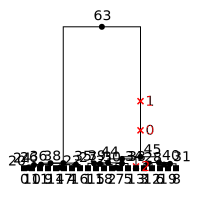

In [20]:
tree_as_svg = tree.draw_svg()  # Create an SVG string 
display(tree_as_svg)  # show it in the notebook (NB: since this is the last command, `display` is redundant here)

In the SVG format, the nodes are marked in black and numbered by node ID. Squares are used for nodes whose genomes we have sampled.
Mutations, on the other hand, are plotted as red crosses, with the red mutation ID beside them.
<div class="alert alert-block alert-info"><b>Note:</b>
Often in these trees, the terminal branches are very short, and the height of the nodes is best plotted on a log scale. This can be done using <code>draw_svg(..., time_scale="log_time")</code>. You can try this above if you like.
    
Many other formatting options are possible, some of which we use below. To look at the help for a function like `draw_svg()` you can type `help(tskit.Tree.draw_svg)` or `?tskit.Tree.draw_svg` in a jupyter notebook, or examine the documentation <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Tree.draw_svg">here</a>. The <a href="https://tskit.dev/tutorials/viz.html">visualization tutorial</a> also gives more guidance. 
</div>

<dl class="exercise"><dt>Exercise 4</dt>
<dd>Plot the first tree in SVG format, and underneath it plot the tree at position 400 Kb, adding the following parameters to each `draw_svg()` call to produce nicer formatting:

* `size=(500, 300)` – to plot the SVG 500 pixels wide and 300 pixels high
* `y_axis=True` – to show a y (time) axis
* `y_ticks=[0, 100, 200, 500, 1000, 2000]` – to use nice tick marks on the y axis

</dd></dl>

In [21]:
# Exercise 3: use draw_svg() to create two SVG trees (the first in the tree sequence and the one at
# position 400Kb), and plot them by calling display(...) twice. They should look quite different


In [22]:
workbook.Q4()

<IPython.core.display.Javascript object>

<dl class="exercise"><dt>Exercise 5</dt>
<dd>Each node in a tree sequence corresponds to an ancestral genome that existed at some point in the past. You can find details of a particular node (e.g. node 9) using <code>ts.node(9)</code>. Use this to find the age of the root (i.e. oldest) node shown in first tree. 
<div class="alert alert-block alert-info"><b>Tip:</b>
    You can check that you have the right node ID by using <code>tree.root</code>.</div>
</dd></dl>

In [23]:
# Exercise 5: print out the age (in generations ago) of the oldest node in the first tree


In [24]:
workbook.Q5()

<IPython.core.display.Javascript object>

Alternatively, you could have printed out the underlying *node table* and looked up the times there. You can get a read-only view of the tables that underly a tree sequence by using the `.tables` attribute:

In [25]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,0,0.00000000,
2,1,0,1,0.00000000,
3,1,0,1,0.00000000,
4,1,0,2,0.00000000,
5,1,0,2,0.00000000,
6,1,0,3,0.00000000,
7,1,0,3,0.00000000,
8,1,0,4,0.00000000,
9,1,0,4,0.00000000,


## Visualising entire tree sequences

It is also possible to plot out all the trees in a tree sequence. When a tree sequence is plotted like this, alternate background shading is used to indicate the region covered by each local tree, and by default an x-axis is plotted, with the ticks below showing the breakpoints between trees, and ticks above showing sites with their mutations (red fleches).

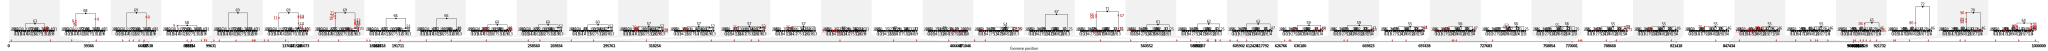

In [26]:
# Tree sequences can be long: you may have to scroll right to see all the trees
ts.draw_svg()  # NB: since this is the final cell output, it will be displayed automatically

However, even in this small tree sequence, plotting out all the trees is a bit unwieldy, and if you have many more samples or trees, this sort of plot quickly becomes overwhelming.

One way to reduce the amount of data being plotted is to visualise only a restricted region of the sequence, for instance only the middle of the genome (e.g. between 400 and 600 Kb, which only contains 6 trees). When plotting in SVG format, this can be done by using the `x_lim` parameter (you can ignore the extra svg parameters defined below, which are simply to aid formatting)

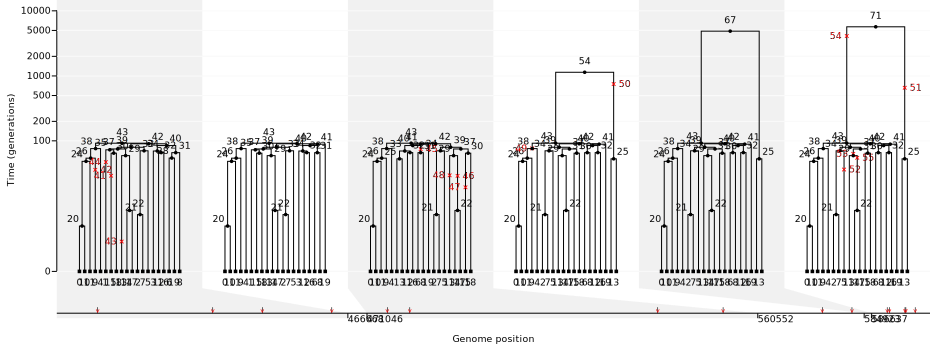

In [27]:
# You can largely ignore the `extra_svg_params` variable defined below: it's just to format nicer plots here
extra_svg_params = dict(
    size=(950, 350),
    root_svg_attributes={"class": workbook.small_class},
    style=workbook.small_style,
    y_axis=True,
    y_ticks=[0, 100, 200, 500, 1000, 2000, 5000, 10000],
    y_gridlines=True,
)

ts.draw_svg(x_lim=(400_000, 600_000), time_scale="log_time", **extra_svg_params)

Instead of using `x_lim`, if you want to work with only the trees in that restricted region, you can create a new tree sequence by removing genealogical information (i.e. deleting the trees) to the right and left. This gives more-or-less the same plot (spot the differences, though!)

After deleting flanking information, the tree sequence has only 8 trees (where an empty flanking region is also counted as a tree).
It now also has only 44 nodes and 15 sites.


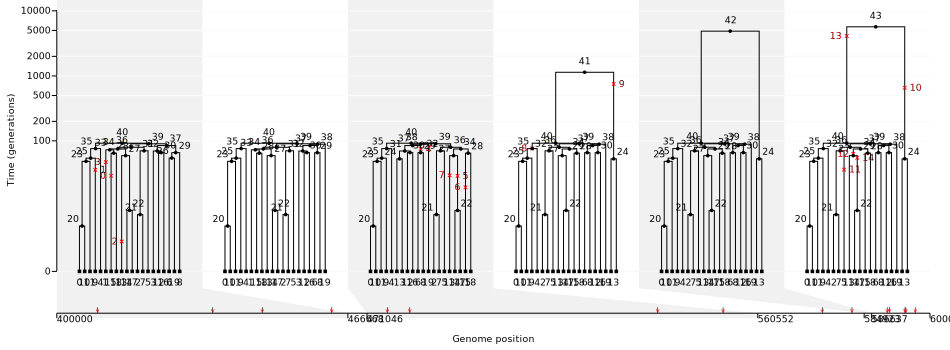

In [28]:
deleted_data_ts = ts.delete_intervals([[0, 400_000], [600_000, 1000_000]])

print(
    "After deleting flanking information, the tree sequence has only",
    deleted_data_ts.num_trees,
    "trees (where an empty flanking region is also counted as a tree).",
)
print(
    "It now also has only",
    deleted_data_ts.num_nodes,
    "nodes and",
    deleted_data_ts.num_sites,
    "sites."
)

# No x_lim parameter needed: by default we don't plot empty flanking regions
deleted_data_ts.draw_svg(time_scale="log_time", **extra_svg_params)

## Simplification

The powerful `.simplify()` method can be used to remove samples from the tree sequence, retaining only the ancestry of a specified set of sample nodes. There are many important uses of this function, for example when running forwards-in-time simulations. Below we simply use it to reduce the amount of data we need to display. 

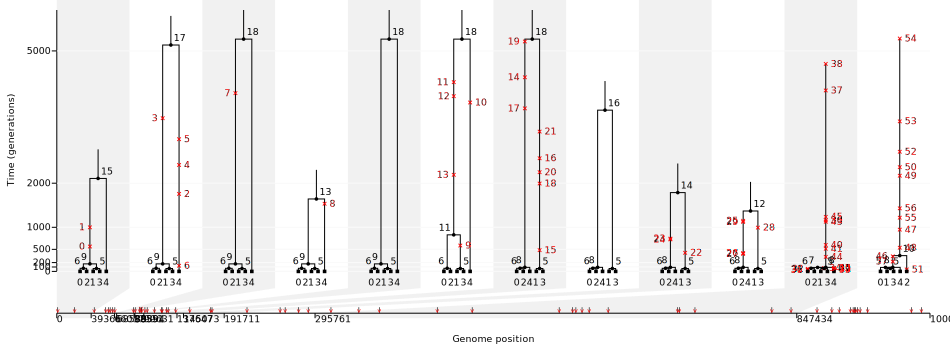

In [29]:
# Simplify ts to retain only the ancestry of samples 5..9
simple_ts = ts.simplify(samples=[5, 6, 7, 8, 9])  # This loses lots of information, but allows nicer plots

simple_ts.draw_svg(**extra_svg_params)

<div class="alert alert-block alert-info"><b>Note:</b>
You may notice in these trees that the branch above all the remaining samples may retain mutations (particularly visible in the rightmost tree. These "root mutations" are fixed (i.e. present in all the samples), so do not appear to create genetic variation between samples.</div>

## Metadata

When either deleting genealogical data or simplifying, you are likely to remove some nodes, edges, sites, and mutations. In turn this means that many of the IDs in the tree sequence can change (for example the sample node IDs have changed in the simplified tree sequence above). If you ever expect to use a modified version of a tree sequence, you can't rely on the IDs of nodes, sites, etc. staying the same.

For this reason, `tskit` allows arbitrary *metadata* to be associated with entities in a tree sequence. For example, variable sites might have a unique name, such as a reference SNP ("rs") ID: there's an example of this at the end of this workbook. A detailed description of metadata in `tskit` is provided in the metadata [documentation](https://tskit.dev/tskit/docs/stable/metadata.html) and [tutorial](https://tskit.dev/tutorials/metadata.html). This workbook merely scratches the surface of what is possible.


As we are about to see, one particularly helpful use of metadata is to allocate names to *individuals* in a tree sequence.

## Individuals and populations

Nodes (particularly sample nodes) are often associated with *individuals* who have had their genomes sequenced. In many cases, individual organisms are diploid, hence each sequenced organism provides *two* sample nodes or genomes (one maternal and one paternal). It can be helpful not only to associate a sample node with an individual, but also to give the individuals *names* (stored in the individuals' metadata).

Similarly, nodes can also be associated with *populations*. `Tskit` has a populations table to contain information about such populations

In [30]:
# Here we print out the information for each sample node
for node_id in sample_node_ids:
    print(ts.node(node_id))

Node(id=0, flags=1, time=0.0, population=0, individual=0, metadata=b'')
Node(id=1, flags=1, time=0.0, population=0, individual=0, metadata=b'')
Node(id=2, flags=1, time=0.0, population=0, individual=1, metadata=b'')
Node(id=3, flags=1, time=0.0, population=0, individual=1, metadata=b'')
Node(id=4, flags=1, time=0.0, population=0, individual=2, metadata=b'')
Node(id=5, flags=1, time=0.0, population=0, individual=2, metadata=b'')
Node(id=6, flags=1, time=0.0, population=0, individual=3, metadata=b'')
Node(id=7, flags=1, time=0.0, population=0, individual=3, metadata=b'')
Node(id=8, flags=1, time=0.0, population=0, individual=4, metadata=b'')
Node(id=9, flags=1, time=0.0, population=0, individual=4, metadata=b'')
Node(id=10, flags=1, time=0.0, population=0, individual=5, metadata=b'')
Node(id=11, flags=1, time=0.0, population=0, individual=5, metadata=b'')
Node(id=12, flags=1, time=0.0, population=0, individual=6, metadata=b'')
Node(id=13, flags=1, time=0.0, population=0, individual=6, me

You can see from the output that node 0 is associated with individual 0, while (say) node 10 is associated with individual 5. We can look at the these individual ids in the individuals table:

<dl class="exercise"><dt>Exercise 6</dt>
<dd>Display the individuals and populations table for the original tree sequence</dd>
</dl>

In [31]:
# Exercise 6a: Display the individuals table


In [32]:
workbook.Q6a()

<IPython.core.display.Javascript object>

In [33]:
# Exercise 6b: Display the populations table


In [34]:
workbook.Q6b()

<IPython.core.display.Javascript object>

In the case above, the individual's metadata is stored in a Python dictionary, with a <code>name</code> key. The name of (say) individual 7 can therefore be obtained from the metadata by <code>ts.individual(7).metadata["name"]</code>

<div class="alert alert-block alert-info"><b>Tip:</b>
    Metadata can be used, for example, to label the sample nodes in a tree visualization with the name of the individual from whom they came. An example of this is provided in the <a href="https://tskit.dev/tutorials/terminology_and_concepts.html#individuals-and-populations">online tutorials</a>.</div>

## Processing variants

When dealing with genomic data, it is common to want to move along the genome, looking at the genetic variation at a number of variable sites. Often there are thousands or millions of variable sites along the genome, so instead of dealing with the variation in all the sites at once, we treat them one-by-one along the genome.


The <code>tskit</code> library gains efficiency in storage and processing by using the trees along the genome to effectively *compress* genetic variation data. The tree sequence `.variants()` method iterates over all the sites in the tree sequence, each time returning a <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Variant">Variant</a> object in which the genetic variation has been decoded. A variant object has three main properties: `.site`, `.alleles` and `.genotypes`:

In [35]:
# For brevity, illustrate using the simplified_ts which has only 5 samples
for v in simple_ts.variants():
    print(
        "Site",
        v.site.id,  # v.site is just a reference to the appropriate site object, e.g. the same as ts.site(0)
        f"(pos {v.site.position}):", 
        v.alleles,
        v.genotypes, # the decoded variation data
    )

Site 0 (pos 1064.0): ('A', 'C') [1 1 1 1 0]
Site 1 (pos 20359.0): ('A', 'C') [1 1 1 1 0]
Site 2 (pos 42877.0): ('C', 'G') [0 0 0 0 1]
Site 3 (pos 56020.0): ('A', 'T') [1 1 1 1 0]
Site 4 (pos 59212.0): ('G', 'C') [0 0 0 0 1]
Site 5 (pos 61130.0): ('C', 'T') [0 0 0 0 1]
Site 6 (pos 64033.0): ('C', 'A') [0 0 0 0 1]
Site 7 (pos 66476.0): ('C', 'G') [1 1 1 1 0]
Site 8 (pos 87693.0): ('A', 'C') [0 0 0 0 1]
Site 9 (pos 89826.0): ('C', 'T') [0 1 0 1 0]
Site 10 (pos 94774.0): ('C', 'T') [0 0 0 0 1]
Site 11 (pos 96396.0): ('T', 'G') [0 0 0 0 0]
Site 12 (pos 97288.0): ('C', 'A') [1 1 1 1 0]
Site 13 (pos 100913.0): ('G', 'C') [1 0 1 0 1]
Site 14 (pos 103531.0): ('C', 'A') [0 1 0 1 0]
Site 15 (pos 111801.0): ('G', 'C') [0 1 0 1 0]
Site 16 (pos 119877.0): ('C', 'T') [1 0 1 0 1]
Site 17 (pos 120660.0): ('T', 'G') [0 1 0 1 0]
Site 18 (pos 125795.0): ('G', 'T') [1 0 1 0 1]
Site 19 (pos 127577.0): ('G', 'T') [0 1 0 1 0]
Site 20 (pos 136236.0): ('G', 'T') [0 1 0 1 0]
Site 21 (pos 152315.0): ('A', 'G') [0

The `.genotypes` array contains the decoded genetic data: i.e. the genetic information for each sample at the given site. This is slightly different from the "genotypes" output by many other bioinformatic packages, in 2 ways:

1. Each entry is the genotype of a single sampled haploid genome. A diploid individual will therefore be represented by 2 entries in the array
2. For efficiency reasons, values in the genotypes array are numbers, not letters like A, T, G, or C.

The genotype value is an index into the `.alleles` array (or `-1` for missing data). In this case, for example, the first four samples in the simplified tree sequence have the allele `A` whereas the fifth has `C`. In this example all the alleles are single letters, but it is also possible to an allele with more or fewer letters, representing insertions or deletions.

Often the numbers in the `.genotypes` array are enough for analysis, but you want the alleles themselves, you need to index into the `alleles` list by hand:

In [36]:
import numpy as np

last_variant = v  # the last variant used in the loop above
print("Last variant: ", v.site.position, v.alleles, v.genotypes, "\n")
site = last_variant.site
genotypes = last_variant.genotypes
allele_array = np.array(last_variant.alleles)  # Convert to a numpy array to allow access by index

print(f"Genetic variation at last site (position {site.position}) is:")
print(allele_array[genotypes])

print("\n... or more verbosely\n")
for sample_id, genotype in zip(simple_ts.samples(), genotypes):
    node = simple_ts.node(sample_id)
    individual = simple_ts.individual(node.individual)
    print(
        f"Sample node {sample_id} from individual {node.individual} "
        f"({individual.metadata['name']}) has allele {allele_array[genotype]}"
    )

Last variant:  990134.0 ('C', 'A') [1 1 0 1 1] 

Genetic variation at last site (position 990134.0) is:
['A' 'A' 'C' 'A' 'A']

... or more verbosely

Sample node 0 from individual 0 (Cat) has allele A
Sample node 1 from individual 1 (Dee) has allele A
Sample node 2 from individual 1 (Dee) has allele C
Sample node 3 from individual 2 (Eli) has allele A
Sample node 4 from individual 2 (Eli) has allele A


In [37]:
workbook.Q7a()

<IPython.core.display.Javascript object>

<dl class="exercise"><dt>Exercise 7</dt>
    <dd>Copy the code cell that printed out the variation at all 56 sites and change it to loop over all 99 variants in the full <code>ts</code>, but print out only the <code>.genotypes</code> attribute of each variant.</dd></dl>

In [38]:
# Exercise 7: iterate over all 99 variants in `ts`, printing out the genotypes at each site


In [39]:
workbook.Q7b()

<IPython.core.display.Javascript object>

Although we have spent some time looking at the  `.variants()` iterator, most of the time you don't actually need to use it: `tskit` provides functions to analyse genetic variation data without decoding the genotypes. This usually involves iterating over the trees in the tree sequence, which can be done very efficiently, as we shall see in the next section.

## Processing trees

When we plotted local trees at two different genomic positions, they looked quite different. This could indicate different sorts of history for different regions of the genome. One way to investigate this is to look at how the trees change along the genome.

A common idiom that underlies many tree sequence algorithms involves moving along the genome by
iterating over all of its [Trees](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Tree). 
To do this you use the
[.trees](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.trees) method. Because trees in a tree sequence are correlated, it is very efficent to move from one tree to an adjacent tree in this way (much more efficent than accessing the trees separately each time using `ts.at`)

In [40]:
for tree in ts.trees():
    print(f"Tree {tree.index} has a root at time {ts.node(tree.root).time} and covers {tree.interval}")

Tree 0 has a root at time 2108.0062486338006 and covers Interval(left=0.0, right=39366.0)
Tree 1 has a root at time 5133.8987188755245 and covers Interval(left=39366.0, right=66037.0)
Tree 2 has a root at time 5267.751078473658 and covers Interval(left=66037.0, right=68538.0)
Tree 3 has a root at time 1642.5979101035928 and covers Interval(left=68538.0, right=88551.0)
Tree 4 has a root at time 5267.751078473658 and covers Interval(left=88551.0, right=89394.0)
Tree 5 has a root at time 5267.751078473658 and covers Interval(left=89394.0, right=99631.0)
Tree 6 has a root at time 5267.751078473658 and covers Interval(left=99631.0, right=137647.0)
Tree 7 has a root at time 3656.7093456281104 and covers Interval(left=137647.0, right=141520.0)
Tree 8 has a root at time 3656.7093456281104 and covers Interval(left=141520.0, right=145073.0)
Tree 9 has a root at time 1786.6709474716697 and covers Interval(left=145073.0, right=180647.0)
Tree 10 has a root at time 1786.6709474716697 and covers Inte

Here's an example of plotting the time of the root along the genome

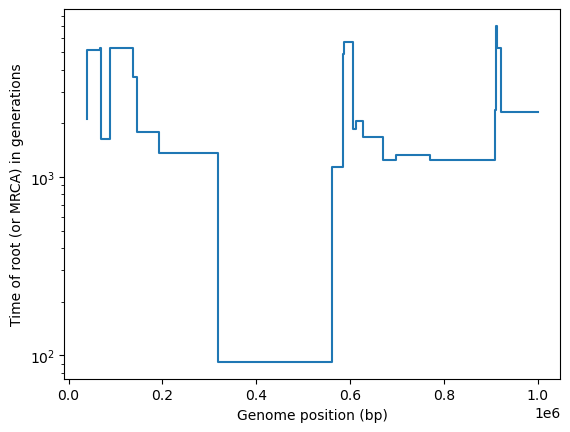

In [41]:
import matplotlib.pyplot as plt

x = []
y = []
for tree in ts.trees():
    x.append(tree.interval.right)
    y.append(ts.node(tree.root).time)
plt.step(x, y)
plt.xlabel("Genome position (bp)")
plt.ylabel(f"Time of root (or MRCA) in {ts.time_units}")
plt.yscale("log")

<dl class="exercise"><dt>Exercise 8</dt>
<dd>Copy and paste the code above, then change it to plot the total branch length of each tree instead of the time of the root node.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Use the <code>.total_branch_length</code> property of the <code>tree</code>. Also, you don't need to reimport matplotlib.pyplot. The plot should look very similar, because trees with recent root nodes are likely to have a short total branch length.</div></dd></dl>


In [42]:
# Exercise 8: plot the total branch length of the trees along the genome


It seems that there might be something unusual about the trees in the middle of this
chromosome: both the root node time and the total branch length are noticably smaller around 400Kb into the sequence. We can investigate this using various built-in statistics.

## Built-in statistics

If you are calculating statistics along the genome, the `tskit` library provides methods for you. This can avoid the need to explicitly iterate over trees by hand. Methods include, for example, the average proportion of variable sites along the genome:

In [43]:
print(
    "Proportion of sites over whole genome:",
    ts.num_sites / ts.sequence_length,
    "(NB: this counts *all* defined sites, not just variable ones)" 
)
print(
    "Equivalent statistical calculation:",
    ts.segregating_sites(),
    "(This is better as it only counts variable sites)"
)

Proportion of sites over whole genome: 9.9e-05 (NB: this counts *all* defined sites, not just variable ones)
Equivalent statistical calculation: 9.8e-05 (This is better as it only counts variable sites)


In [44]:
# Another advantage of the built-in stats framework is that stats can be output in windows along the genome
import numpy as np
window_locations, step = np.linspace(0, ts.sequence_length, num=21, retstep=True)
site_density = ts.segregating_sites(windows=window_locations)
print(f"Variable site density in windows of {step/1000} Kb:")
print(site_density)

Variable site density in windows of 50.0 Kb:
[8.0e-05 1.8e-04 1.8e-04 1.0e-04 6.0e-05 8.0e-05 4.0e-05 6.0e-05 6.0e-05
 6.0e-05 2.0e-05 1.6e-04 1.2e-04 8.0e-05 8.0e-05 1.0e-04 4.0e-05 1.4e-04
 2.2e-04 1.0e-04]


<dl class="exercise"><dt>Exercise 9</dt><dd>Use <code>plt.stairs(site_density, window_locations)</code> to plot the density of variable sites over the genome in windows.
<div class="alert alert-block alert-info">
<b>Tip:</b> It will look a little nicer if you get rid of the vertical lines at the start and end of the plot by specifing <code>baseline=None</code> as an additional parameter to the <code>plt.stairs(...)</code> function.</div></dd></dl>

In [45]:
# Exercise 9: plot the density of variable sites in fixed-sized windows along the genome


### A duality between branch lengths and site variation

You may have noticed that the plot above looks pretty similar to the previous ones. That highlights an important point. If most mutations are neutral, and they occur randomly in time, then the number of mutations in a tree is determined by the total branch length in the tree: the more branches, or the longer each branch, the more mutations are likely to be observed. 

Moreover, when mutations are rare, each mutation results in a new variable site. So the proportion of variable sites can be thought of as an estimate of total branch length. In `tskit`, we can switch to this "branch length" version of the statistic by using the `mode` parameter, which defaults to `"site"` but can be set instead to `"branch"`.

In other words, the total branch length is a *genealogical equivalent* of the density of variable sites. In `tskit`, both can be obtained using the `segregating_sites()` statistical method, illustrated below:

<div class="alert alert-block alert-info">
<b>Note:</b>
The segregating sites statistic illustrates a general principle. There is an underlying duality between measures of branch length in local trees and statistics based on genetic variation at individual sites. We will see this later in this and further workbooks. <a href="https://doi.org/10.1534/genetics.120.303253">This paper</a> provides a full discussion, and there's a basic introduction in <a href="https://tskit.dev/tutorials/no_mutations.html#genetic-statistics-and-branch-length-equivalents">our online tutorial</a>.</div>

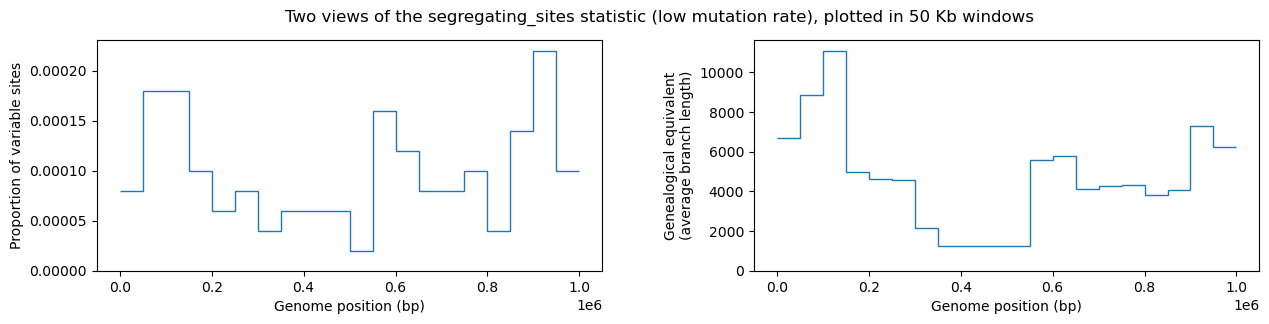

In [46]:
# Use the branch length as the statistic
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 3))
plt.subplots_adjust(wspace=0.3)
site_density = ts.segregating_sites(windows=window_locations)
branch_length = ts.segregating_sites(windows=window_locations, mode="branch")

# Same as the previous plot
ax1.stairs(site_density, window_locations, baseline=None)
ax1.set_xlabel("Genome position (bp)")
ax1.set_ylabel(f"Proportion of variable sites")

# Genealogical equivalent (mode="branch")
ax2.stairs(branch_length, window_locations, baseline=None)
ax2.set_xlabel("Genome position (bp)")
ax2.set_ylabel(f"Genealogical equivalent\n(average branch length)")

plt.suptitle(
    "Two views of the segregating_sites statistic (low mutation rate)"
    f", plotted in {step/1000:.0f} Kb windows")

plt.show()

<dl class="exercise"><dt>Exercise 10</dt>
<dd>As the number of mutations increases, the left hand plot should become more and more like the right hand one. We can test this by using <code>msprime.sim_mutations</code> (described in a later workshop) to overlay huge numbers of neutral mutations onto the tree sequence. You should try this below

<div class="alert alert-block alert-info">
    <b>Note:</b> If you specify <code>windows=ts.breakpoints(as_array=True)</code> (or the shorthand <code>windows="trees"</code>) then you will reproduce the plot you made in Exercise 7.</div>
</dd></dl>

In [47]:
import msprime
mutation_rate = 2e-7  # Higher than the human average of ~1e-8
high_mutation_ts = msprime.sim_mutations(ts, rate=mutation_rate, random_seed=123)

# Exercise 10: illustrate that with high mutation rate, the density of variable sites tends
# to the average branch length statistic. Do this by using the same plotting code as in the
# previous code cell, but substituting `high_mutation_ts` for `ts`.


Another basic statistic is the genetic diversity ($\pi$) of a set of sequences, which measures the average genetic difference between all pairs of samples in your dataset. Where there has been recent selection, we expect a dip in diversity. Here's what the diversity looks like in our example tree sequence:

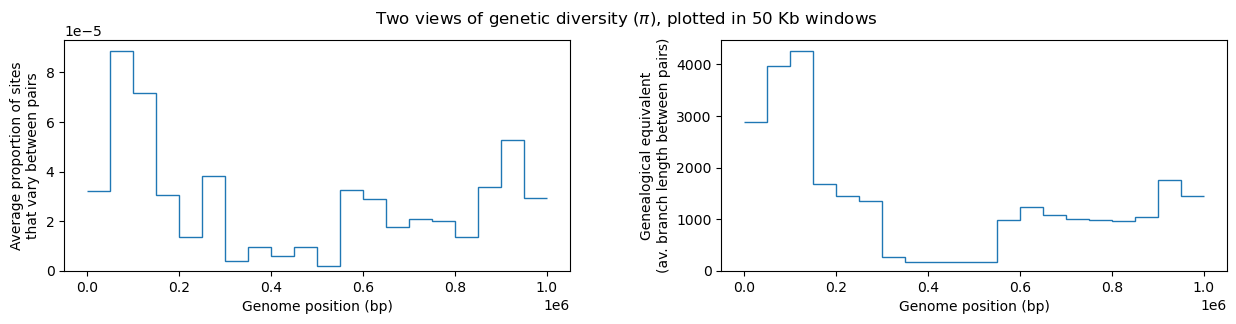

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 3))
plt.subplots_adjust(wspace=0.3)

window_locations, step = np.linspace(0, ts.sequence_length, num=21, retstep=True)
diversity_site = ts.diversity(windows=window_locations)
diversity_branch = ts.diversity(windows=window_locations, mode="branch")

ax1.stairs(diversity_site, window_locations, baseline=None)
ax1.set_xlabel("Genome position (bp)")
ax1.set_ylabel(f"Average proportion of sites\nthat vary between pairs")

# Genealogical equivalent (mode="branch")
ax2.stairs(diversity_branch, window_locations, baseline=None)
ax2.set_xlabel("Genome position (bp)")
ax2.set_ylabel(f"Genealogical equivalent\n(av. branch length between pairs)")

plt.suptitle(r"Two views of genetic diversity ($\pi$), " + f"plotted in {step/1000:.0f} Kb windows")

plt.show()

<dl class="exercise"><dt>Exercise 11</dt>
<dd>The difference between the proportion of segregating sites and the genetic diversity, suitably scaled, is known as <em>Tajima's D</em>, which under neutral expectations, and a constant population size, is expected to be zero on average. It is available as the <code>.Tajimas_D()</code> statistic.

Copy and paste the code above, then change it to plot Tajima's D, additionally using <code>ax1.axhline(0, linestyle=":")</code> and <code>ax2.axhline(0, linestyle=":")</code> to show a dotted horizontal line at zero.

<div class="alert alert-block alert-info">
    <b>Note:</b> A large number of other statistics are available in tskit, as described <a href="https://tskit.dev/tskit/docs/stable/stats.html">here</a></div>
</dd></dl>

In [49]:
# Exercise 11: plot Tajima's D in windows along the genome


### The Allele Frequency Spectrum (AFS)

Many population genetic statistics are based on the allele (or site) frequency spectrum (AFS), that is, the number of alleles found in just one sample (singletons), the number in two samples (doubletons), in three (tripletons) etc. This also has a branch-length interpretation: the number of singletons is an estimate of the sum length of all branches above one sample (i.e. terminal branches), the number of doubletons is an estimate of the sum length of all branches above 2 samples, etc.

We can obtain the "normal" AFS and the "branch length" AFS using the `.allele_frequency_spectrum()` method:

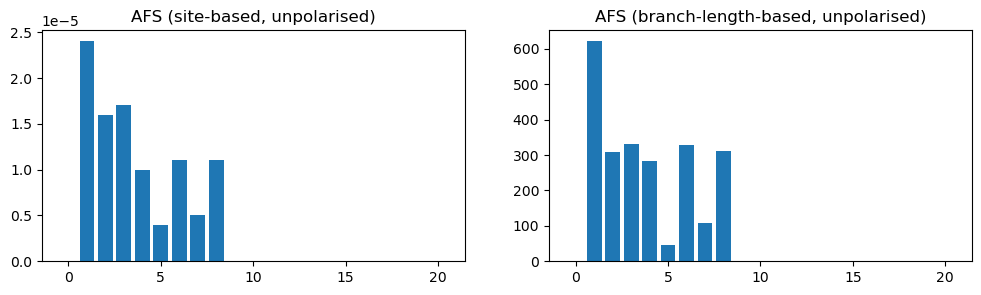

In [50]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

afs = ts.allele_frequency_spectrum()
ax1.bar(range(ts.num_samples + 1), afs)
ax1.set_title("AFS (site-based, unpolarised)")


afs = ts.allele_frequency_spectrum(mode="branch")
ax2.bar(range(ts.num_samples + 1), afs)
ax2.set_title("AFS (branch-length-based, unpolarised)")

plt.show()

<div class="alert alert-block alert-info"><b>Note:</b>
    By default the <code>.allele_frequency_spectrum()</code> method returns the "folded" or unpolarized AFS that doesn't <a href="https://tskit.dev/tskit/docs/stable/stats.html#sec-stats-polarisation">take account of the ancestral state</a>, so that e.g. an allele present in 19 out of 20 samples is treated the same as an allele that is present in 1 out of 20 samples. Here, this results in the bars covering the range 1..9 rather than 1..19. This can be changed by passing <code>polarised=True</code> as a parameter.</div>

Branch lengths in the trees can change depending on demographic effects (which tend to influence trees across the whole genome) and natural selection (which tends to influence trees in certain parts of the genome only). The tree sequence we have been using was simulated with a *selective sweep* (a major bout of positive selection) occurring in the middle of the genome at 500 Kb. 

The effect on the trees at the start versus in the middle of the sequence is very clear, on plotting:

Tree sequence from 0 Kb to 50 Kb


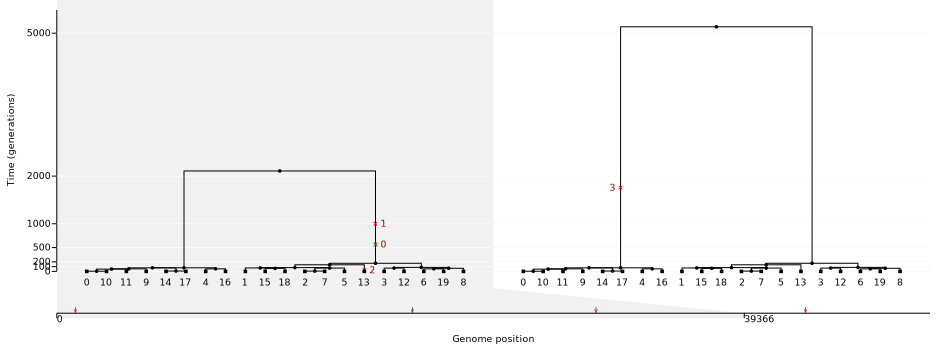

In [51]:
labels={i: i for i in ts.samples()}  # only show the labels for sample nodes

print(f"Tree sequence from 0 Kb to 50 Kb")
ts.draw_svg(x_lim=(0, 50_000), node_labels=labels, **extra_svg_params)

Tree sequence from 475 Kb to 525 Kb


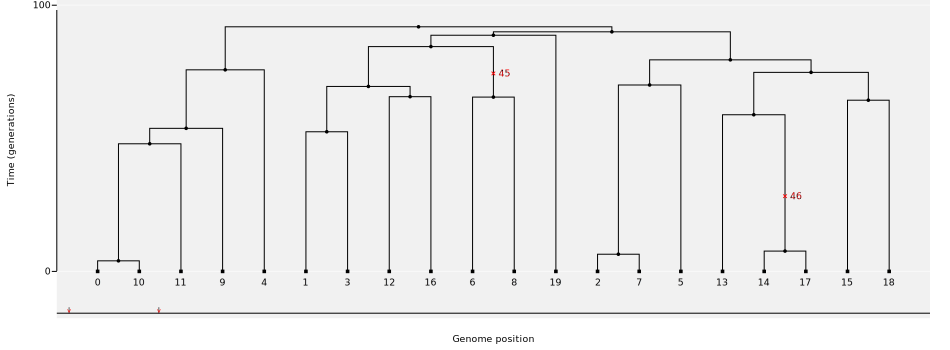

In [52]:
print(f"Tree sequence from 475 Kb to 525 Kb")
ts.draw_svg(x_lim=(475_000, 525_000), node_labels=labels, **extra_svg_params)

The bottom tree, which is in the middle of the selected region, lacks the deep branches seen in the top tree. This results in a smaller number of mutations per unit length in a selected region, and the mutations that *do* exist tend to be at *lower frequency* (e.g. singletons and doubletons). This will be reflected in the site frequency spectra in the different regions.

Currently in tskit, to restrict statistics to certain regions, it's easiest to use `.delete_intervals()` (or its converse, `.keep_intervals()`), coupled with the `.trim()` method that removes empty flanking regions of a tree sequence (running statistics directly on restricted regions is planned for a future tskit update).

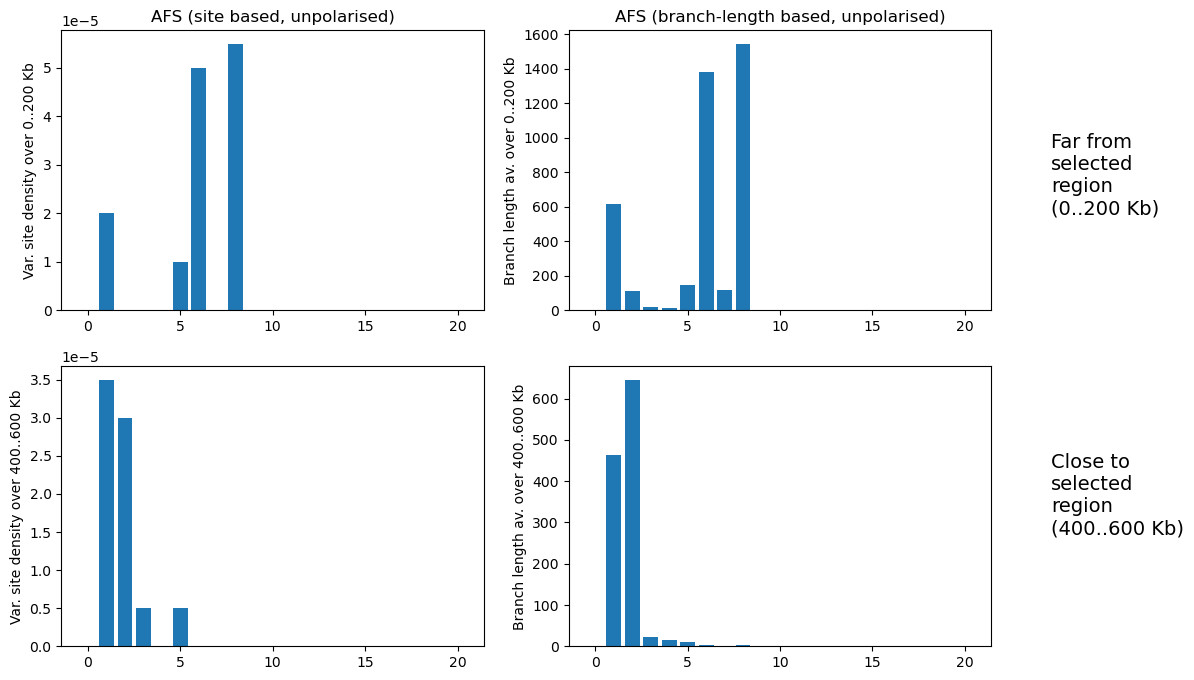

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ts_0_200Kb = ts.keep_intervals([[0, 200_000]]).trim()
ts_400_600Kb = ts.keep_intervals([[400_000, 600_000]]).trim()
x = range(ts.num_samples + 1)

afs = ts_0_200Kb.allele_frequency_spectrum()
axes[0, 0].bar(x, afs)
axes[0, 0].set_title("AFS (site based, unpolarised)")
axes[0, 0].set_ylabel("Var. site density over 0..200 Kb")

afs = ts_0_200Kb.allele_frequency_spectrum(mode="branch")
axes[0, 1].bar(x, afs)
axes[0, 1].set_title("AFS (branch-length based, unpolarised)")
axes[0, 1].set_ylabel("Branch length av. over 0..200 Kb")

afs = ts_400_600Kb.allele_frequency_spectrum()
axes[1, 0].bar(x, afs)
axes[1, 0].set_ylabel("Var. site density over 400..600 Kb")

afs = ts_400_600Kb.allele_frequency_spectrum(mode="branch")
axes[1, 1].bar(x, afs)
axes[1, 1].set_ylabel("Branch length av. over 400..600 Kb")

plt.figtext(0.95, 0.65, "Far from\nselected\nregion\n(0..200 Kb)", fontsize=14)
plt.figtext(0.95, 0.25, "Close to\nselected\nregion\n(400..600 Kb)", fontsize=14)
plt.show()

The differences between the upper and lower AFS plots clearly reflect the tree differences between the regions. Several tests for detecting selection are based on the differences in frequency classes, which reflect relative branch lengths of the tree. Alternative approaches for detecting selection measure the lengths of haplotypes or
ages of common ancestors (these metrics are currently being implemented in `tskit`)

## Saving and exporting data

At the start of this workbook we used `tskit.load` to load a tree sequence from a file. To save to a file you can use the `.dump()` method of a tree sequence object (by convention, a `.trees` suffix is used for these files).

Although tree sequences already compress genomic data extremely well (especially for simulated data, which can be 4 or 5 orders of magnitude smaller than the comparable VCF file), it is possible to compress tree sequences even further, at the cost of having to decompress them before use. This compression is done by the `tszip` library, and is recommended for large datasets which are intended for download online or sending to others:

In [54]:
import tszip

ts.dump("data/copy_of_ts.trees")  # Save an uncompressed tree sequence
tszip.compress(ts, "data/ts.tsz")  # Save a compressed tree sequence to a file
ts_copy = tszip.decompress("data/ts.tsz")  # Load a compressed tree sequence from a file

It's also possible to export tree sequences to different formats. Note, however, that
not only are these usually much larger files, but that analysis is usually much faster
when performed by built-in tskit functions than by exporting and using alternative
software. If you have a large tree sequence, you should *try to avoid exporting
to other formats*.

### Newick and Nexus format

The most common format for interchanging tree data is Newick. 
We can export to a newick format string quite easily. This can be useful for
interoperating with existing tree processing libraries but is very inefficient for
large trees. There is also no support for including sites and mutations in the trees.

In [55]:
tree = ts.first()
print(tree.newick(precision=3))

(((5:53.820,17:53.820):21.906,((15:7.628,18:7.628):66.942,(10:53.746,(12:47.940,(1:3.970,11:3.970):43.970):5.806):20.824):1.156):2032.280,(((9:65.482,(7:53.982,20:53.982):11.500):18.966,(4:69.486,13:69.486):14.962):86.189,(14:138.731,((6:70.028,(3:6.454,8:6.454):63.574):9.446,(2:72.524,(16:64.314,19:64.314):8.210):6.950):59.257):31.906):1937.369);


For an entire set of trees, you can use the Nexus file format, which acts as a container
for a list of Newick format trees, one per line:

In [56]:
print(simple_ts.as_nexus(precision=2, include_alignments=False))

#NEXUS
BEGIN TAXA;
  DIMENSIONS NTAX=5;
  TAXLABELS n0 n1 n2 n3 n4;
END;
BEGIN TREES;
  TREE t0.00^39366.00 = [&R] (n4:2108.01,((n1:65.48,n3:65.48):105.15,(n0:70.03,n2:70.03):100.61):1937.37);
  TREE t39366.00^66037.00 = [&R] (n4:5133.90,((n1:65.48,n3:65.48):105.15,(n0:70.03,n2:70.03):100.61):4963.26);
  TREE t66037.00^68538.00 = [&R] (n4:5267.75,((n1:65.48,n3:65.48):105.15,(n0:70.03,n2:70.03):100.61):5097.11);
  TREE t68538.00^88551.00 = [&R] (n4:1642.60,((n1:65.48,n3:65.48):105.15,(n0:70.03,n2:70.03):100.61):1471.96);
  TREE t88551.00^89394.00 = [&R] (n4:5267.75,((n1:65.48,n3:65.48):105.15,(n0:70.03,n2:70.03):100.61):5097.11);
  TREE t89394.00^99631.00 = [&R] (n4:5267.75,((n1:65.48,n3:65.48):763.48,(n0:70.03,n2:70.03):758.94):4438.79);
  TREE t99631.00^137647.00 = [&R] ((n1:65.48,n3:65.48):5202.27,(n4:91.89,(n0:70.03,n2:70.03):21.86):5175.86);
  TREE t137647.00^145073.00 = [&R] ((n1:65.48,n3:65.48):3591.23,(n4:91.89,(n0:70.03,n2:70.03):21.86):3564.82);
  TREE t145073.00^191711.00 = [

### VCF

The standard way of interchanging genetic variation data is the Variant Call Format, 
for which tskit has basic support:

<div class="alert alert-block alert-info"><b>Note:</b>
The write_vcf method takes a file object as a parameter; to get it to write out to the
notebook here we ask it to write to stdout.</div>

In [57]:
import sys
simple_ts.write_vcf(sys.stdout)

##fileformat=VCFv4.2
##source=tskit 0.5.5
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=1000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2
1	1064	0	A	C	.	PASS	.	GT	1	1|1	1|0
1	20359	1	A	C	.	PASS	.	GT	1	1|1	1|0
1	42877	2	C	G	.	PASS	.	GT	0	0|0	0|1
1	56020	3	A	T	.	PASS	.	GT	1	1|1	1|0
1	59212	4	G	C	.	PASS	.	GT	0	0|0	0|1
1	61130	5	C	T	.	PASS	.	GT	0	0|0	0|1
1	64033	6	C	A	.	PASS	.	GT	0	0|0	0|1
1	66476	7	C	G	.	PASS	.	GT	1	1|1	1|0
1	87693	8	A	C	.	PASS	.	GT	0	0|0	0|1
1	89826	9	C	T	.	PASS	.	GT	0	1|0	1|0
1	94774	10	C	T	.	PASS	.	GT	0	0|0	0|1
1	96396	11	T	G	.	PASS	.	GT	0	0|0	0|0
1	97288	12	C	A	.	PASS	.	GT	1	1|1	1|0
1	100913	13	G	C	.	PASS	.	GT	1	0|1	0|1
1	103531	14	C	A	.	PASS	.	GT	0	1|0	1|0
1	111801	15	G	C	.	PASS	.	GT	0	1|0	1|0
1	119877	16	C	T	.	PASS	.	GT	1	0|1	0|1
1	120660	17	T	G	.	PASS	.	GT	0	1|0	1|0
1	125795	18	G	T	.	PASS	.	GT	1	0|1	0|1
1	127577	19	G	T	.	PASS	.	GT	0	1|0	1|0
1	136236	20	G	

# Further exercises with real data

If you have time after finishing this workbook, we have provided an [extra workbook](./WorkshopExtra.ipynb) investigating some real datasets. This focusses on a set of tree sequences which describe a "[Unified genealogy of modern and ancient human genomes](https://doi.org/10.1126/science.abi8264)", and which are publicly available for download and analysis.

## Acknowledgements
Parts of this workbook are heavily based on [Georgia Tsambos' Jupyter notebooks](https://github.com/gtsambos/2022-ts-workshops).